# BERTweet with Interweaving Fine-Tuned Approach on Disability and Race

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Imports

In [ ]:
!pip install -q transformers

In [ ]:
!pip install -q tensorflow-addons

In [ ]:
!pip3 install -q emoji==0.6.0

In [ ]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_addons as tfa
import transformers
from transformers import AutoTokenizer,TFRobertaModel

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Functions and Constants

In [2]:
def to_arrays(df):
  X = df['comment_text'].to_numpy()
  y = df['toxicity_binary'].to_numpy()
  return X, y

In [3]:
MAX_SEQUENCE_LENGTH = 128

In [4]:
def tokenizing_pipeline(X, tokenizer):
  bert_tokenized = tokenizer(list(X),
                max_length=MAX_SEQUENCE_LENGTH,
                truncation=True,
                padding='max_length',
                return_tensors='tf')
  bert_inputs = [bert_tokenized.input_ids,
                 bert_tokenized.token_type_ids,
                 bert_tokenized.attention_mask]
  return bert_inputs

In [5]:
def build_bertweet_cls_model(max_sequence_length=MAX_SEQUENCE_LENGTH,
                          hidden_size=100, 
                          dropout=0.3,
                          learning_rate=0.0001,
                          num_train_layers=0):

    # freeze all pre-trained BERTweet layers
    if num_train_layers == 0:
      bertweet_model.trainable = False

    # partially freeze the first n pre-trained BERTweet layers
    else:
        for layer_num in range(num_train_layers):
            bertweet_model.roberta.encoder.layer[layer_num].trainable = False
    
    input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}      

    # Use the same bertweet model instance
    bert_out = bertweet_model(bert_inputs)

    cls_token = bert_out[0][:, 0, :]

    
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(cls_token)

    hidden = tf.keras.layers.Dropout(dropout)(hidden)  

    f1_score = tfa.metrics.F1Score(1, threshold = 0.5)

    classification = tf.keras.layers.Dense(1, activation='sigmoid', name='classification_layer')(hidden)
    
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
    
    classification_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
                                 metrics=[tf.keras.metrics.BinaryAccuracy(),
                                        tf.keras.metrics.Precision(),
                                        tf.keras.metrics.Recall(),
                                        f1_score])

    return classification_model

## Load All Available Data for Disability and Race

In [6]:
# Disability
disability_train_df = pd.read_csv('drive/MyDrive/data/disability-dataset-train-augmented.csv')
disability_val_df = pd.read_csv('drive/MyDrive/data/disability-dataset-val-augmented.csv')
disability_test_df = pd.read_csv('drive/MyDrive/data/disability-dataset-test-augmented.csv')

X_disability_train, y_disability_train = to_arrays(disability_train_df)
X_disability_val, y_disability_val = to_arrays(disability_val_df)
X_disability_test, y_disability_test = to_arrays(disability_test_df)

# Race
# chunks are only for train and val
race_train_chunk1_df = pd.read_csv('drive/MyDrive/data/race-dataset-train-chunk1-augmented.csv')
race_val_chunk1_df = pd.read_csv('drive/MyDrive/data/race-dataset-val-chunk1-augmented.csv')
race_train_chunk2_df = pd.read_csv('drive/MyDrive/data/race-dataset-train-chunk2-augmented.csv')
race_val_chunk2_df = pd.read_csv('drive/MyDrive/data/race-dataset-val-chunk2-augmented.csv')

X_race_train_chunk1, y_race_train_chunk1 = to_arrays(race_train_chunk1_df)
X_race_val_chunk1, y_race_val_chunk1 = to_arrays(race_val_chunk1_df)

X_race_train_chunk2, y_race_train_chunk2 = to_arrays(race_train_chunk2_df)
X_race_val_chunk2, y_race_val_chunk2 = to_arrays(race_val_chunk2_df)

# single test set for race
race_test_df = pd.read_csv('drive/MyDrive/data/race-dataset-test-augmented.csv')
X_race_test, y_race_test = to_arrays(race_test_df)

In [7]:
X_disability_train[1]

' mental disability is extremely physical'

In [8]:
X_disability_train[9]

' There are many different types of disabilities. For example: mental, cognitive, visual, hearing, physical, and speech. Some people physically cannot speak English'

In [9]:
len(X_disability_train)

24904

In [10]:
X_race_train_chunk1[0]

' the narrative of african american men as criminals has historically been a tool used to justify their death'

In [11]:
X_race_train_chunk2[1]

'they are the ones with the most nappy-headed kids'

In [12]:
len(X_race_train_chunk2)

35014

## Load BERTweet Model from_pretrained()

In [13]:
bertweet_tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base",
                                                    use_fast=False,
                                                    normalization=True,
                                                    add_special_tokens=True,
                                                    return_attention_mask=True)
bertweet_model = TFRobertaModel.from_pretrained("vinai/bertweet-base")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some layers from the model checkpoint at vinai/bertweet-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/bertweet-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [14]:
bertweet_model.summary()

Model: "tf_roberta_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLayer  multiple                 134899968 
 )                                                               
                                                                 
Total params: 134,899,968
Trainable params: 134,899,968
Non-trainable params: 0
_________________________________________________________________


## Tokenize Data Splits

In [15]:
# Takes 2 min to run
# Disability
bertweet_disability_train_inputs = tokenizing_pipeline(X_disability_train, bertweet_tokenizer)
bertweet_disability_test_inputs = tokenizing_pipeline(X_disability_test, bertweet_tokenizer)
bertweet_disability_val_inputs = tokenizing_pipeline(X_disability_val, bertweet_tokenizer)

# Race Chunks
bertweet_race_train_chunk1_inputs = tokenizing_pipeline(X_race_train_chunk1, bertweet_tokenizer)
bertweet_race_val_chunk1_inputs = tokenizing_pipeline(X_race_val_chunk1, bertweet_tokenizer)

bertweet_race_train_chunk2_inputs = tokenizing_pipeline(X_race_train_chunk2, bertweet_tokenizer)
bertweet_race_val_chunk2_inputs = tokenizing_pipeline(X_race_val_chunk2, bertweet_tokenizer)

# Race Test
bertweet_race_test_inputs = tokenizing_pipeline(X_race_test, bertweet_tokenizer)

# Calculate Class Weights for Each Group

Get class weights for disability train set:

In [16]:
neg, pos = np.bincount(y_disability_train)
total = neg + pos
print('Disability Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

disability_class_weight = {0: weight_for_0, 1: weight_for_1}

print('Disability Weight for class 0: {:.2f}'.format(weight_for_0))
print('Disability Weight for class 1: {:.2f}'.format(weight_for_1))

Disability Examples:
    Total: 24904
    Positive: 13009 (52.24% of total)

Disability Weight for class 0: 1.05
Disability Weight for class 1: 0.96


Get class weights for race train set - chunk #1:

In [17]:
neg, pos = np.bincount(y_race_train_chunk1)
total = neg + pos
print('Race Train Chunk 1 Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

race_chunk1_class_weight = {0: weight_for_0, 1: weight_for_1}

print('Race Train Chunk Weight for class 0: {:.2f}'.format(weight_for_0))
print('Race Train Chunk Weight for class 1: {:.2f}'.format(weight_for_1))

Race Train Chunk 1 Examples:
    Total: 35014
    Positive: 17775 (50.77% of total)

Race Train Chunk Weight for class 0: 1.02
Race Train Chunk Weight for class 1: 0.98


Get class weights for race train set - chunk #2:

In [18]:
neg, pos = np.bincount(y_race_train_chunk2)
total = neg + pos
print('Race Train Chunk 1 Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

race_chunk2_class_weight = {0: weight_for_0, 1: weight_for_1}

print('Race Train Chunk Weight for class 0: {:.2f}'.format(weight_for_0))
print('Race Train Chunk Weight for class 1: {:.2f}'.format(weight_for_1))

Race Train Chunk 1 Examples:
    Total: 35014
    Positive: 17743 (50.67% of total)

Race Train Chunk Weight for class 0: 1.01
Race Train Chunk Weight for class 1: 0.99


In [19]:
# hyperparameters
batch_size=24
num_train_layers=8
learning_rate=1e-6

# Build Disability Model

In [20]:
disability_model = build_bertweet_cls_model(num_train_layers=num_train_layers, learning_rate=learning_rate)
disability_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                              

# Build Race Model

In [21]:
race_model = build_bertweet_cls_model(num_train_layers=num_train_layers, learning_rate=learning_rate)
race_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                            

# Interweaving Fine-Tuning: Train Disability and Race Models on ther Respective Data

### Round 1: Train Disability Model for 1 epochs

In [22]:
disability_round1_history = disability_model.fit(bertweet_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertweet_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 100s 81ms/step - loss: 0.6126 - binary_accuracy: 0.6610 - precision: 0.6824 - recall: 0.6565 - f1_score: 0.6692 - val_loss: 0.4722 - val_binary_accuracy: 0.7770 - val_precision: 0.8000 - val_recall: 0.7599 - val_f1_score: 0.7794


# Round 2: Train Race Model on Chunk#1 for 1 epoch

In [23]:
race_round2_history = race_model.fit(bertweet_race_train_chunk1_inputs,
                                          y_race_train_chunk1,
                                          validation_data=(bertweet_race_val_chunk1_inputs, y_race_val_chunk1),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=race_chunk1_class_weight)

1459/1459 [==============================] - 137s 83ms/step - loss: 0.5479 - binary_accuracy: 0.7208 - precision_1: 0.7116 - recall_1: 0.7567 - f1_score: 0.7334 - val_loss: 0.4436 - val_binary_accuracy: 0.7879 - val_precision_1: 0.8232 - val_recall_1: 0.7455 - val_f1_score: 0.7824


# Round 3: Train Disability Model for 1 epoch

In [24]:
disability_round3_history = disability_model.fit(bertweet_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertweet_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 81s 78ms/step - loss: 0.4581 - binary_accuracy: 0.7911 - precision: 0.8094 - recall: 0.7848 - f1_score: 0.7969 - val_loss: 0.4206 - val_binary_accuracy: 0.8037 - val_precision: 0.8292 - val_recall: 0.7826 - val_f1_score: 0.8053


# Round 4: Train Race Model on Chunk#2 for 1 epoch

In [25]:
race_round4_history = race_model.fit(bertweet_race_train_chunk2_inputs,
                                          y_race_train_chunk2,
                                          validation_data=(bertweet_race_val_chunk2_inputs, y_race_val_chunk2),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=race_chunk2_class_weight)

1459/1459 [==============================] - 118s 81ms/step - loss: 0.4444 - binary_accuracy: 0.7958 - precision_1: 0.8062 - recall_1: 0.7859 - f1_score: 0.7959 - val_loss: 0.3939 - val_binary_accuracy: 0.8240 - val_precision_1: 0.8244 - val_recall_1: 0.8225 - val_f1_score: 0.8234


# Round 5: Train Disability Model for 1 epoch

In [26]:
disability_round5_history = disability_model.fit(bertweet_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertweet_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 81s 78ms/step - loss: 0.4297 - binary_accuracy: 0.8036 - precision: 0.8244 - recall: 0.7930 - f1_score: 0.8084 - val_loss: 0.4062 - val_binary_accuracy: 0.8184 - val_precision: 0.8545 - val_recall: 0.7831 - val_f1_score: 0.8173


# Round 6: Train Race Model on Chunk#1 for 1 epoch

In [27]:
race_round6_history = race_model.fit(bertweet_race_train_chunk1_inputs,
                                          y_race_train_chunk1,
                                          validation_data=(bertweet_race_val_chunk1_inputs, y_race_val_chunk1),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=race_chunk1_class_weight)

1459/1459 [==============================] - 118s 81ms/step - loss: 0.4166 - binary_accuracy: 0.8122 - precision_1: 0.8236 - recall_1: 0.8019 - f1_score: 0.8126 - val_loss: 0.3956 - val_binary_accuracy: 0.8172 - val_precision_1: 0.8387 - val_recall_1: 0.7957 - val_f1_score: 0.8166



# Round 7: Train Disability Model for 1 epoch

In [28]:
disability_round7_history = disability_model.fit(bertweet_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertweet_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 81s 78ms/step - loss: 0.4118 - binary_accuracy: 0.8150 - precision: 0.8366 - recall: 0.8026 - f1_score: 0.8192 - val_loss: 0.3949 - val_binary_accuracy: 0.8232 - val_precision: 0.8521 - val_recall: 0.7975 - val_f1_score: 0.8239


# Round 8: Train Race Model on Chunk#2 for 1 epoch

In [29]:
race_round8_history = race_model.fit(bertweet_race_train_chunk2_inputs,
                                          y_race_train_chunk2,
                                          validation_data=(bertweet_race_val_chunk2_inputs, y_race_val_chunk2),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=race_chunk2_class_weight)

1459/1459 [==============================] - 118s 81ms/step - loss: 0.4038 - binary_accuracy: 0.8187 - precision_1: 0.8302 - recall_1: 0.8074 - f1_score: 0.8186 - val_loss: 0.3647 - val_binary_accuracy: 0.8386 - val_precision_1: 0.8600 - val_recall_1: 0.8080 - val_f1_score: 0.8332


# Round 9: Train Disability Model for 1 epoch

In [30]:
disability_round9_history = disability_model.fit(bertweet_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertweet_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 81s 78ms/step - loss: 0.4024 - binary_accuracy: 0.8218 - precision: 0.8455 - recall: 0.8062 - f1_score: 0.8254 - val_loss: 0.3883 - val_binary_accuracy: 0.8268 - val_precision: 0.8546 - val_recall: 0.8026 - val_f1_score: 0.8278


# Round 10: Train Race Model on Chunk#1 for 1 epoch

In [31]:
race_round10_history = race_model.fit(bertweet_race_train_chunk1_inputs,
                                          y_race_train_chunk1,
                                          validation_data=(bertweet_race_val_chunk1_inputs, y_race_val_chunk1),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=race_chunk1_class_weight)

1459/1459 [==============================] - 118s 81ms/step - loss: 0.3880 - binary_accuracy: 0.8251 - precision_1: 0.8371 - recall_1: 0.8138 - f1_score: 0.8253 - val_loss: 0.3769 - val_binary_accuracy: 0.8286 - val_precision_1: 0.8564 - val_recall_1: 0.7991 - val_f1_score: 0.8267


# Round 11: Train Disability Model for 1 epoch

In [32]:
disability_round11_history = disability_model.fit(bertweet_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertweet_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 81s 78ms/step - loss: 0.3890 - binary_accuracy: 0.8276 - precision: 0.8505 - recall: 0.8128 - f1_score: 0.8312 - val_loss: 0.3809 - val_binary_accuracy: 0.8302 - val_precision: 0.8613 - val_recall: 0.8017 - val_f1_score: 0.8304


# Round 12: Train Race Model on Chunk#2 for 1 epoch

In [33]:
race_round12_history = race_model.fit(bertweet_race_train_chunk2_inputs,
                                          y_race_train_chunk2,
                                          validation_data=(bertweet_race_val_chunk2_inputs, y_race_val_chunk2),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=race_chunk2_class_weight)

1459/1459 [==============================] - 118s 81ms/step - loss: 0.3804 - binary_accuracy: 0.8295 - precision_1: 0.8425 - recall_1: 0.8160 - f1_score: 0.8290 - val_loss: 0.3481 - val_binary_accuracy: 0.8477 - val_precision_1: 0.8437 - val_recall_1: 0.8527 - val_f1_score: 0.8482


# Round 13: Train Disability Model for 1 epoch

In [34]:
disability_round13_history = disability_model.fit(bertweet_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertweet_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 81s 78ms/step - loss: 0.3825 - binary_accuracy: 0.8321 - precision: 0.8545 - recall: 0.8179 - f1_score: 0.8358 - val_loss: 0.3760 - val_binary_accuracy: 0.8336 - val_precision: 0.8458 - val_recall: 0.8305 - val_f1_score: 0.8381


# Round 14: Train Race Model on Chunk#1 for 1 epoch

In [35]:
race_round14_history = race_model.fit(bertweet_race_train_chunk1_inputs,
                                          y_race_train_chunk1,
                                          validation_data=(bertweet_race_val_chunk1_inputs, y_race_val_chunk1),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=race_chunk1_class_weight)

1459/1459 [==============================] - 118s 81ms/step - loss: 0.3697 - binary_accuracy: 0.8358 - precision_1: 0.8473 - recall_1: 0.8252 - f1_score: 0.8361 - val_loss: 0.3624 - val_binary_accuracy: 0.8360 - val_precision_1: 0.8485 - val_recall_1: 0.8272 - val_f1_score: 0.8377


# Round 15: Train Disability Model for 1 epoch

In [36]:
disability_round15_history = disability_model.fit(bertweet_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertweet_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 81s 78ms/step - loss: 0.3750 - binary_accuracy: 0.8350 - precision: 0.8586 - recall: 0.8190 - f1_score: 0.8383 - val_loss: 0.3736 - val_binary_accuracy: 0.8360 - val_precision: 0.8640 - val_recall: 0.8114 - val_f1_score: 0.8369


# Round 16: Train Race Model on Chunk#2 for 1 epoch

In [37]:
race_round16_history = race_model.fit(bertweet_race_train_chunk2_inputs,
                                          y_race_train_chunk2,
                                          validation_data=(bertweet_race_val_chunk2_inputs, y_race_val_chunk2),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=race_chunk2_class_weight)

1459/1459 [==============================] - 118s 81ms/step - loss: 0.3658 - binary_accuracy: 0.8356 - precision_1: 0.8471 - recall_1: 0.8242 - f1_score: 0.8355 - val_loss: 0.3351 - val_binary_accuracy: 0.8566 - val_precision_1: 0.8788 - val_recall_1: 0.8266 - val_f1_score: 0.8519


# Round 17: Train Disability Model for 1 epoch

In [38]:
disability_round17_history = disability_model.fit(bertweet_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertweet_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 81s 78ms/step - loss: 0.3683 - binary_accuracy: 0.8391 - precision: 0.8629 - recall: 0.8227 - f1_score: 0.8423 - val_loss: 0.3715 - val_binary_accuracy: 0.8406 - val_precision: 0.8653 - val_recall: 0.8203 - val_f1_score: 0.8422


# Round 18: Train Race Model on Chunk#1 for 1 epoch

In [39]:
race_round18_history = race_model.fit(bertweet_race_train_chunk1_inputs,
                                          y_race_train_chunk1,
                                          validation_data=(bertweet_race_val_chunk1_inputs, y_race_val_chunk1),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=race_chunk1_class_weight)

1459/1459 [==============================] - 118s 81ms/step - loss: 0.3572 - binary_accuracy: 0.8407 - precision_1: 0.8509 - recall_1: 0.8319 - f1_score: 0.8413 - val_loss: 0.3557 - val_binary_accuracy: 0.8418 - val_precision_1: 0.8750 - val_recall_1: 0.8061 - val_f1_score: 0.8391


# Plots for Disability Model

In [50]:
disability_train_f1_scores = [disability_round1_history.history['f1_score'][0][0], 
                     disability_round3_history.history['f1_score'][0][0],
                     disability_round5_history.history['f1_score'][0][0],
                     disability_round7_history.history['f1_score'][0][0],
                     disability_round9_history.history['f1_score'][0][0],
                     disability_round11_history.history['f1_score'][0][0],
                     disability_round13_history.history['f1_score'][0][0],
                     disability_round15_history.history['f1_score'][0][0],
                     disability_round17_history.history['f1_score'][0][0]]
disability_val_f1_scores = [disability_round1_history.history['val_f1_score'][0][0],
                     disability_round3_history.history['val_f1_score'][0][0],
                     disability_round5_history.history['val_f1_score'][0][0],
                     disability_round7_history.history['val_f1_score'][0][0],
                     disability_round9_history.history['val_f1_score'][0][0],
                     disability_round11_history.history['val_f1_score'][0][0],
                     disability_round13_history.history['val_f1_score'][0][0],
                     disability_round15_history.history['val_f1_score'][0][0],
                     disability_round17_history.history['val_f1_score'][0][0]]
disability_train_loss = [disability_round1_history.history['loss'][0],
                     disability_round3_history.history['loss'][0],
                     disability_round5_history.history['loss'][0],
                     disability_round7_history.history['loss'][0],
                     disability_round9_history.history['loss'][0],
                     disability_round11_history.history['loss'][0],
                     disability_round13_history.history['loss'][0],
                     disability_round15_history.history['loss'][0],
                     disability_round17_history.history['loss'][0]]
disability_val_loss = [disability_round1_history.history['val_loss'][0],
                     disability_round3_history.history['val_loss'][0],
                     disability_round5_history.history['val_loss'][0],
                     disability_round7_history.history['val_loss'][0],
                     disability_round9_history.history['val_loss'][0],
                     disability_round11_history.history['val_loss'][0],
                     disability_round13_history.history['val_loss'][0],
                     disability_round15_history.history['val_loss'][0],
                     disability_round17_history.history['val_loss'][0]]
disability_train_binary_accuracy = [disability_round1_history.history['binary_accuracy'][0],
                     disability_round3_history.history['binary_accuracy'][0],
                     disability_round5_history.history['binary_accuracy'][0],
                     disability_round7_history.history['binary_accuracy'][0],
                     disability_round9_history.history['binary_accuracy'][0],
                     disability_round11_history.history['binary_accuracy'][0],
                     disability_round13_history.history['binary_accuracy'][0],
                     disability_round15_history.history['binary_accuracy'][0],
                     disability_round17_history.history['binary_accuracy'][0]]
disability_val_binary_accuracy = [disability_round1_history.history['val_binary_accuracy'][0],
                     disability_round3_history.history['val_binary_accuracy'][0],
                     disability_round5_history.history['val_binary_accuracy'][0],
                     disability_round7_history.history['val_binary_accuracy'][0],
                     disability_round9_history.history['val_binary_accuracy'][0],
                     disability_round11_history.history['val_binary_accuracy'][0],
                     disability_round13_history.history['val_binary_accuracy'][0],
                     disability_round15_history.history['val_binary_accuracy'][0],
                     disability_round17_history.history['val_binary_accuracy'][0]]

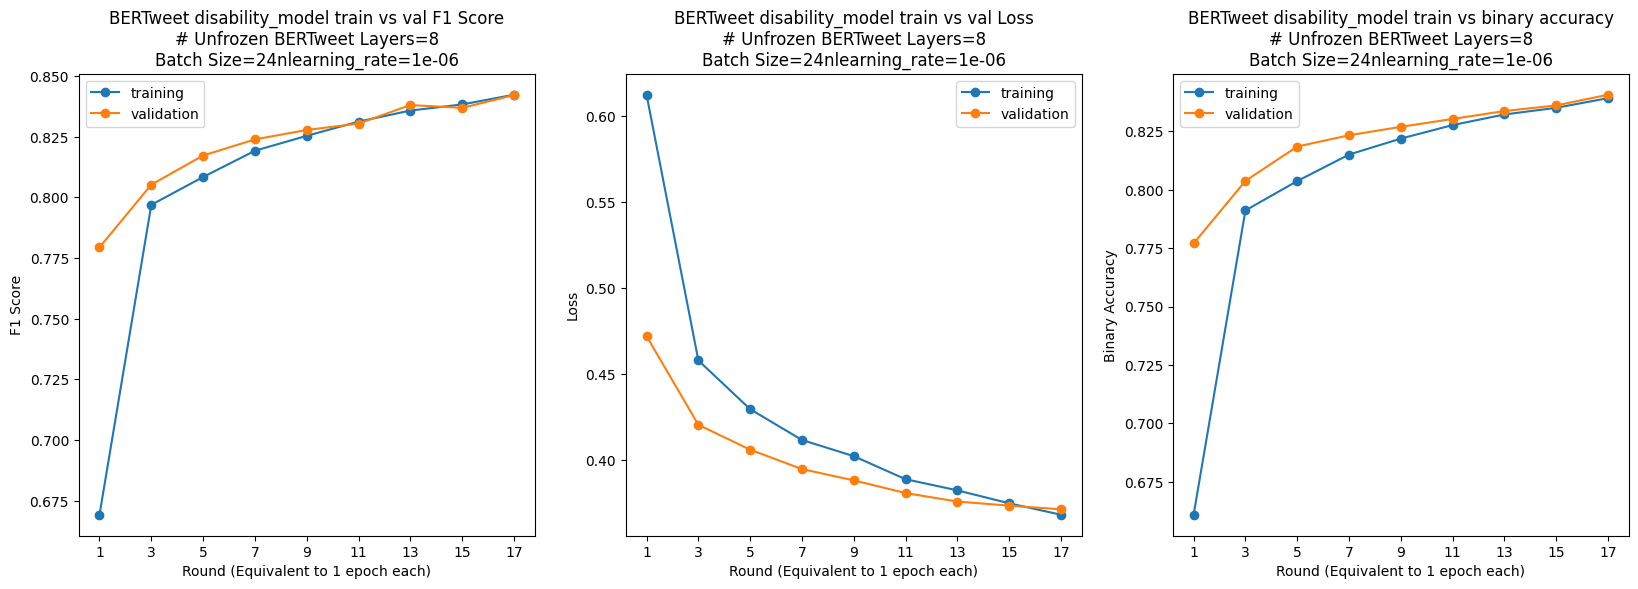

In [62]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(1, 3, figsize=(20,6))

# F1 Score
axis[0].plot(disability_train_f1_scores, label="training", marker='o')
axis[0].plot(disability_val_f1_scores, label="validation", marker='o')
axis[0].legend()
axis[0].set_ylabel('F1 Score')
axis[0].set_xlabel('Round (Equivalent to 1 epoch each)')
axis[0].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], ['1', '3', '5', '7', '9', '11', '13', '15', '17'])
axis[0].set_title('BERTweet disability_model train vs val F1 Score\n'+'# Unfrozen BERTweet Layers='+str(num_frozen_layers)+'\nBatch Size='+str(batch_size)+'nlearning_rate='+str(learning_rate))

# Loss
axis[1].plot(disability_train_loss, label="training", marker='o')
axis[1].plot(disability_val_loss, label="validation", marker='o')
axis[1].legend()
axis[1].set_ylabel('Loss')
axis[1].set_xlabel('Round (Equivalent to 1 epoch each)')
axis[1].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], ['1', '3', '5', '7', '9', '11', '13', '15', '17'])
axis[1].set_title('BERTweet disability_model train vs val Loss\n'+'# Unfrozen BERTweet Layers='+str(num_frozen_layers)+'\nBatch Size='+str(batch_size)+'nlearning_rate='+str(learning_rate))

# Binary Accuracy
axis[2].plot(disability_train_binary_accuracy, label="training", marker='o')
axis[2].plot(disability_val_binary_accuracy, label="validation", marker='o')
axis[2].legend()
axis[2].set_ylabel('Binary Accuracy')
axis[2].set_xlabel('Round (Equivalent to 1 epoch each)')
axis[2].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], ['1', '3', '5', '7', '9', '11', '13', '15', '17'])
axis[2].set_title('BERTweet disability_model train vs binary accuracy\n'+'# Unfrozen BERTweet Layers='+str(num_frozen_layers)+'\nBatch Size='+str(batch_size)+'nlearning_rate='+str(learning_rate))
  
# Combine all the operations and display
plt.show()

# Plots for Race Model

In [57]:
race_train_f1_scores = [race_round2_history.history['f1_score'][0][0],
                     race_round4_history.history['f1_score'][0][0],
                     race_round6_history.history['f1_score'][0][0],
                     race_round8_history.history['f1_score'][0][0],
                     race_round10_history.history['f1_score'][0][0],
                     race_round12_history.history['f1_score'][0][0],
                     race_round14_history.history['f1_score'][0][0],
                     race_round16_history.history['f1_score'][0][0],
                     race_round18_history.history['f1_score'][0][0]]
race_val_f1_scores = [race_round2_history.history['val_f1_score'][0][0],
                     race_round4_history.history['val_f1_score'][0][0],
                     race_round6_history.history['val_f1_score'][0][0],
                     race_round8_history.history['val_f1_score'][0][0],
                     race_round10_history.history['val_f1_score'][0][0],
                     race_round12_history.history['val_f1_score'][0][0],
                     race_round14_history.history['val_f1_score'][0][0],
                     race_round16_history.history['val_f1_score'][0][0],
                     race_round18_history.history['val_f1_score'][0][0]]
race_train_loss = [race_round2_history.history['loss'][0],
                     race_round4_history.history['loss'][0],
                     race_round6_history.history['loss'][0],
                     race_round8_history.history['loss'][0],
                     race_round10_history.history['loss'][0],
                     race_round12_history.history['loss'][0],
                     race_round14_history.history['loss'][0],
                     race_round16_history.history['loss'][0],
                     race_round18_history.history['loss'][0]]
race_val_loss = [race_round2_history.history['val_loss'][0],
                     race_round4_history.history['val_loss'][0],
                     race_round6_history.history['val_loss'][0],
                     race_round8_history.history['val_loss'][0],
                     race_round10_history.history['val_loss'][0],
                     race_round12_history.history['val_loss'][0],
                     race_round14_history.history['val_loss'][0],
                     race_round16_history.history['val_loss'][0],
                     race_round18_history.history['val_loss'][0]]
race_train_binary_accuracy = [race_round2_history.history['binary_accuracy'][0],
                     race_round4_history.history['binary_accuracy'][0],
                     race_round6_history.history['binary_accuracy'][0],
                     race_round8_history.history['binary_accuracy'][0],
                     race_round10_history.history['binary_accuracy'][0],
                     race_round12_history.history['binary_accuracy'][0],
                     race_round14_history.history['binary_accuracy'][0],
                     race_round16_history.history['binary_accuracy'][0],
                     race_round18_history.history['binary_accuracy'][0]]
race_val_binary_accuracy = [race_round2_history.history['val_binary_accuracy'][0],
                     race_round4_history.history['val_binary_accuracy'][0],
                     race_round6_history.history['val_binary_accuracy'][0],
                     race_round8_history.history['val_binary_accuracy'][0],
                     race_round10_history.history['val_binary_accuracy'][0],
                     race_round12_history.history['val_binary_accuracy'][0],
                     race_round14_history.history['val_binary_accuracy'][0],
                     race_round16_history.history['val_binary_accuracy'][0],
                     race_round18_history.history['val_binary_accuracy'][0]]


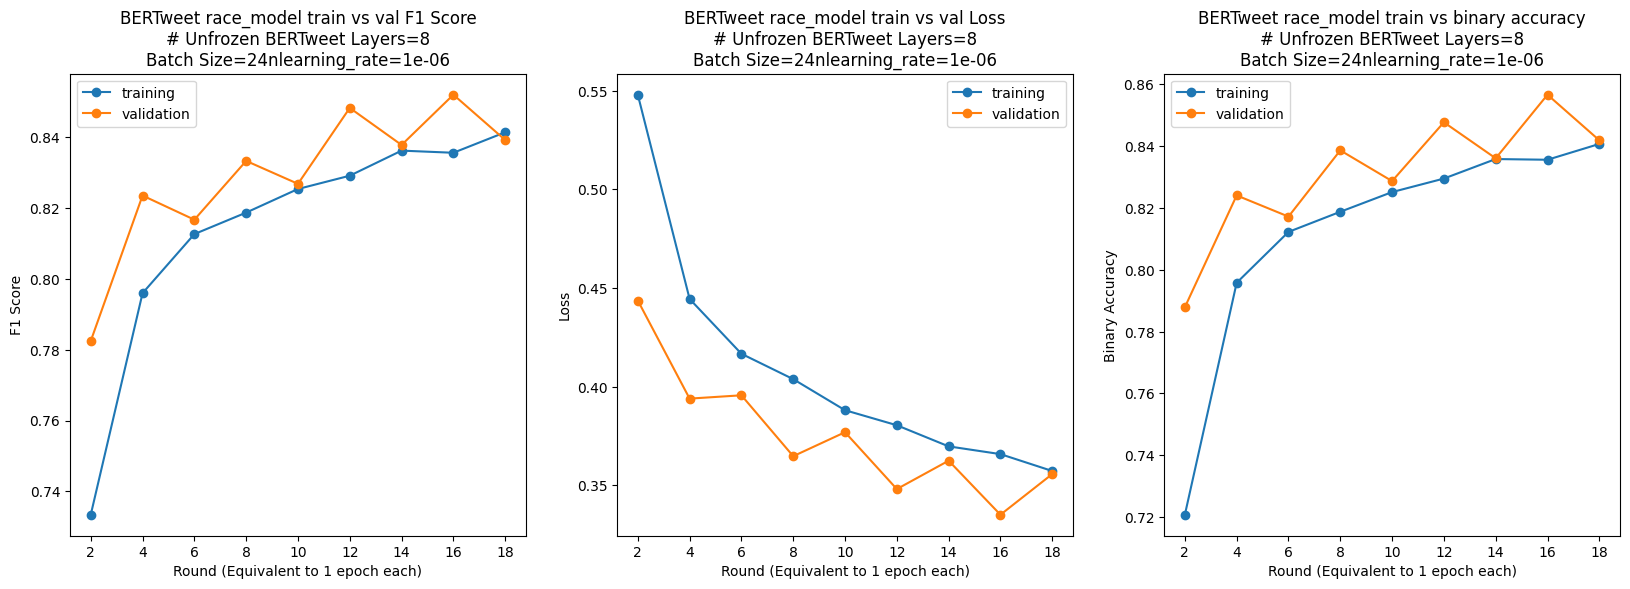

In [63]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(1, 3, figsize=(20,6))

# F1 Score
axis[0].plot(race_train_f1_scores, label="training", marker='o')
axis[0].plot(race_val_f1_scores, label="validation", marker='o')
axis[0].legend()
axis[0].set_ylabel('F1 Score')
axis[0].set_xlabel('Round (Equivalent to 1 epoch each)')
axis[0].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], ['2', '4', '6', '8', '10', '12', '14', '16', '18'])
axis[0].set_title('BERTweet race_model train vs val F1 Score\n'+'# Unfrozen BERTweet Layers='+str(num_frozen_layers)+'\nBatch Size='+str(batch_size)+'nlearning_rate='+str(learning_rate))

# Loss
axis[1].plot(race_train_loss, label="training", marker='o')
axis[1].plot(race_val_loss, label="validation", marker='o')
axis[1].legend()
axis[1].set_ylabel('Loss')
axis[1].set_xlabel('Round (Equivalent to 1 epoch each)')
axis[1].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], ['2', '4', '6', '8', '10', '12', '14', '16', '18'])
axis[1].set_title('BERTweet race_model train vs val Loss\n'+'# Unfrozen BERTweet Layers='+str(num_frozen_layers)+'\nBatch Size='+str(batch_size)+'nlearning_rate='+str(learning_rate))

# Binary Accuracy
axis[2].plot(race_train_binary_accuracy, label="training", marker='o')
axis[2].plot(race_val_binary_accuracy, label="validation", marker='o')
axis[2].legend()
axis[2].set_ylabel('Binary Accuracy')
axis[2].set_xlabel('Round (Equivalent to 1 epoch each)')
axis[2].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], ['2', '4', '6', '8', '10', '12', '14', '16', '18'])
axis[2].set_title('BERTweet race_model train vs binary accuracy\n'+'# Unfrozen BERTweet Layers='+str(num_frozen_layers)+'\nBatch Size='+str(batch_size)+'nlearning_rate='+str(learning_rate))
  
# Combine all the operations and display
plt.show()

# Save Model Weights

In [64]:
disability_model.save_weights('drive/MyDrive/model_checkpoints/Official_BERTweet_Disability_Race_Interwoven_disability.hdf5')
race_model.save_weights('drive/MyDrive/model_checkpoints/Official_BERTweet_Disability_Race_Interwoven_race.hdf5')

# Previous Results

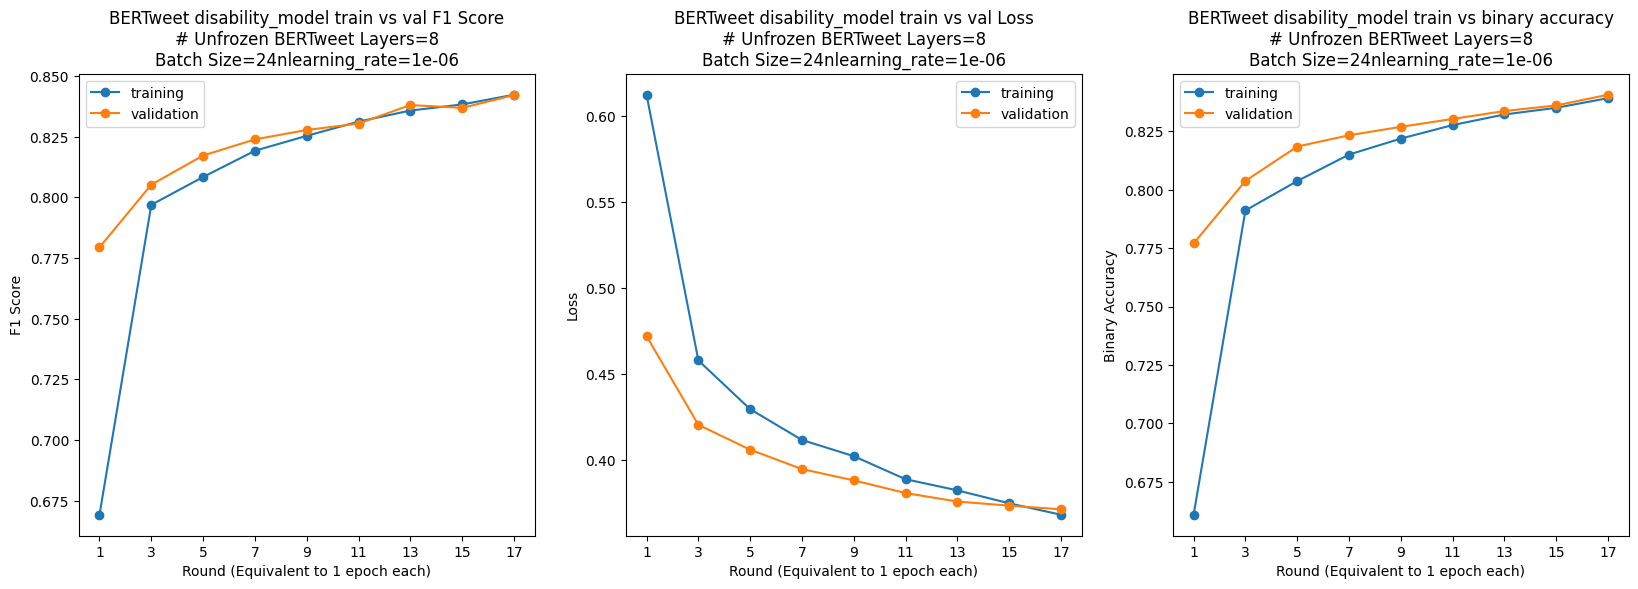

In [ ]:
# DISABILITY MODEL

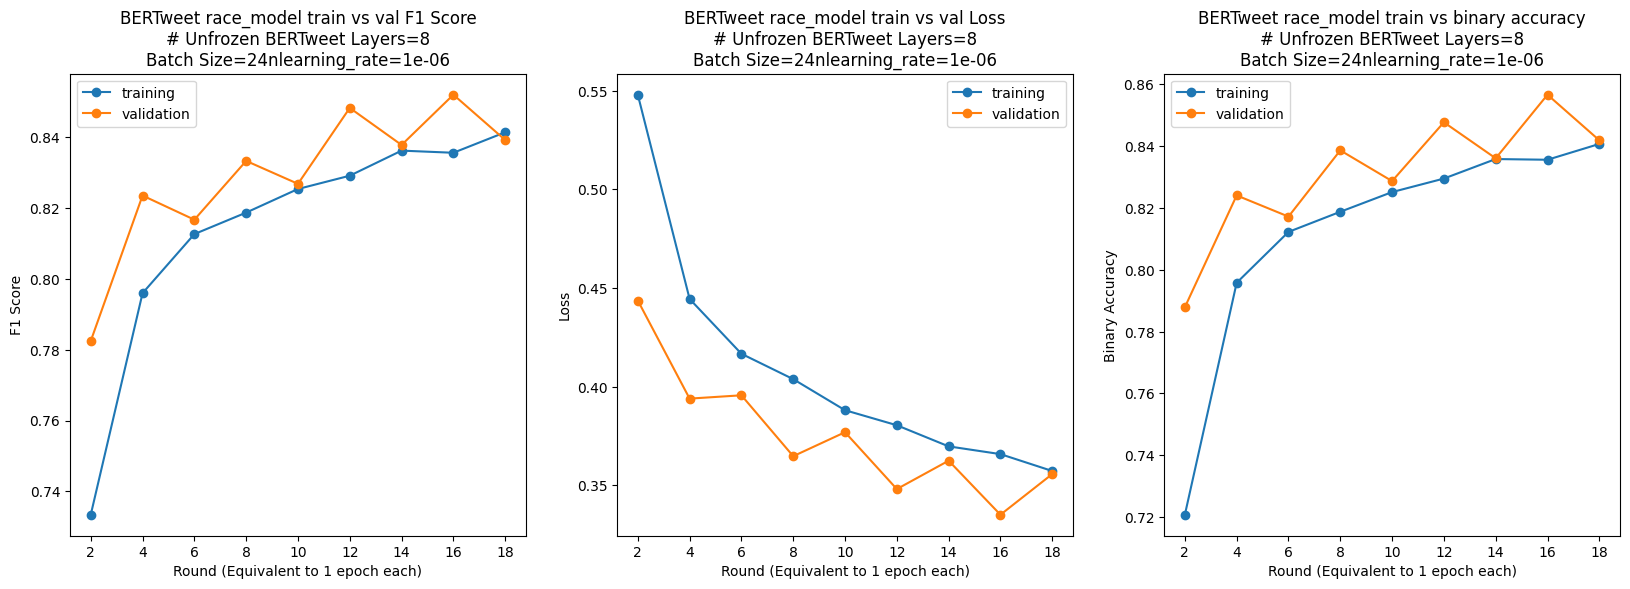

In [ ]:
# RACE MODEL